# Reds Hackathon 2024
# Team: Booth's Batters
### Emily Hapgood, Michael Sepe, Vlad Hes, Luke Mutz
### 2/5/24

In [1]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import tensorflow as tf

import statsmodels.api as sm
from itertools import combinations
from joblib import Parallel, delayed

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [2]:
# Reading in the data 
fan = pd.read_csv(r'C:\Users\micha\OneDrive\Desktop\reds_hackathon\Booths_Batters\fangraphs_season_level.csv')
savant = pd.read_csv(r'C:\Users\micha\OneDrive\Desktop\reds_hackathon\savant_pitch_level.csv')

In [3]:
# Here we conngial the savant data down to pitching metrics of each pitcher
# yearly_metrics = pd.read_csv(r'C:\Users\micha\OneDrive\Desktop\reds_hackathon\Booths_Batters\yearly_metrics.csv')

In [4]:
# Cleaning the fangraphs data for variables that we do not want/need
toKeep = ['MLBAMID', 'Name', 'Throws', 'Role', 'Season'] + fan.columns[9:75].tolist() + fan.columns[85:96].tolist() + fan.columns[107:111].tolist() \
            + fan.columns[132:136].tolist() + ['HardHit', 'HardHit_pct', 'botERA'] + fan.columns[274:278].tolist() + ['Stuff_plus', 'Location_plus', 'Pitching_plus']
fan = fan[toKeep]
fan = pd.get_dummies(fan, columns = ['Throws'])
print('Size before cleaning:', fan.shape)
print()

print('NaN columns with all pitchers present')
nanColumns = fan.columns[fan.isna().any()].tolist()
print(nanColumns)
print()

fanPitch = fan.copy()
fanPitch = fanPitch[fanPitch['Pitches'] >= 30]
print('NaN columns with pitchers filtered with >= 30 pitches')
nanColumnsPitch = fanPitch.columns[fanPitch.isna().any()].tolist()
print(nanColumnsPitch)
print()

#30 leaves 4 columns with NaN instead of 23, a lot of pitchers with under 30 pitches upon inspection have false data anyway. 
#Like k_pct being 0 with k non equal to 0 and p non equal to 0. Removing anyone with under 30 removes 307/3325 pitchers

#cleaning OContact_pct (NaN cause by OSwing_pct = 0)
fanPitch.loc[fanPitch['OSwing_pct']==0, 'OContact_pct'] = 0

#replacing all NaN in stuff+, location+, pitching+ with 100, as 100 is average baseline
fanPitch[['Stuff_plus','Location_plus','Pitching_plus']] = fanPitch[['Stuff_plus','Location_plus','Pitching_plus']].fillna(100)
nanColumnsPitch = fanPitch.columns[fanPitch.isna().any()].tolist()

print('Checking Nan columns and shape of the final dataframe')
print(nanColumnsPitch)
fanPitch.shape

Size before cleaning: (3325, 101)

NaN columns with all pitchers present
['SIERA', 'OSwing_pct', 'ZSwing_pct', 'OContact_pct', 'ZContact_pct', 'Contact_pct', 'Zone_pct', 'FStrike_pct', 'Soft_pct', 'Med_pct', 'Hard_pct', 'EV', 'LA', 'Barrel_pct', 'HardHit_pct', 'botERA', 'botOvr', 'botStf', 'botCmd', 'botxRV100', 'Stuff_plus', 'Location_plus', 'Pitching_plus']

NaN columns with pitchers filtered with >= 30 pitches
['OContact_pct', 'Stuff_plus', 'Location_plus', 'Pitching_plus']

Checking Nan columns and shape of the final dataframe
[]


(3018, 101)

In [6]:
# list of metrics for namings
metrics = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 
           'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 
           'release_extension', 'release_pos_y', 'spin_axis', 'pitch_type']

# Isolating the kinematic metrics
physical_metrics_to_keep = ['game_year', 'pitch_type',  'release_speed', 'release_pos_x',
       'release_pos_z', 'pitcher','p_throws',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y',
       'spin_axis']

pdf = savant[physical_metrics_to_keep]

# Getting most frequently thorwn pitches 
pitch_counts = pdf.groupby(['game_year', 'pitcher', 'pitch_type']).size().reset_index(name='pitch_type_count')
total_pitches = pdf.groupby(['game_year', 'pitcher']).size().reset_index(name='total_pitches')
top_pitches = pitch_counts.groupby(['game_year', 'pitcher']).apply(lambda x: x.nlargest(3, 'pitch_type_count')).reset_index(drop=True)
top_pitches = pd.merge(top_pitches, total_pitches, on=['game_year', 'pitcher'])

# Merge with the original DataFrame with only relevant rows
filtered_pdf = pd.merge(pdf, top_pitches[['game_year', 'pitcher', 'pitch_type']], on=['game_year', 'pitcher', 'pitch_type'])

# Getting mean vals
mean_values = filtered_pdf.groupby(['game_year', 'pitcher', 'pitch_type']).agg({
    'release_speed': 'mean', 'release_pos_x': 'mean', 'release_pos_z': 'mean',
    'pfx_x': 'mean', 'pfx_z': 'mean', 'plate_x': 'mean', 'plate_z': 'mean', 
    'vx0': 'mean', 'vy0': 'mean', 'vz0': 'mean', 'ax': 'mean', 'ay': 'mean', 'az': 'mean',
    'effective_speed': 'mean', 'release_spin_rate': 'mean', 'release_extension': 'mean',
    'release_pos_y': 'mean', 'spin_axis': 'mean'
}).reset_index()

mean_values = pd.merge(mean_values, top_pitches[['game_year', 'pitcher', 'pitch_type', 'pitch_type_count', 'total_pitches']], 
                       on=['game_year', 'pitcher', 'pitch_type'])
mean_values['pitch_frequency'] = mean_values['pitch_type_count'] / mean_values['total_pitches']
mean_values.drop(columns=['pitch_type_count'], inplace=True)


# Assign rank based on frequency for each pitcher within each game year
mean_values['rank'] = mean_values.groupby(['game_year', 'pitcher']).cumcount() + 1

# Filter and reshape
reshaping_columns = ['game_year', 'pitcher', 'rank'] + metrics
reshaping_df = mean_values[reshaping_columns]
reshaped_df = reshaping_df.pivot(index=['game_year', 'pitcher'], columns='rank', values=metrics)

# Renaming the columns to fit a format
reshaped_df.columns = ['{}_{}'.format(metric, rank) for metric, rank in reshaped_df.columns]
reshaped_df.reset_index(inplace= True)

yearly_metrics = reshaped_df.copy()

In [7]:
# drop third pitch and all pitchers who have NaN values in the _3 column (only have one pitch)

# # Drop the 'Unnamed: 0' column
# if 'Unnamed: 0' in yearly_metrics.columns:
#     yearly_metrics = yearly_metrics.drop('Unnamed: 0', axis=1)

# if 'pitch_type_1' in yearly_metrics.columns:
#     yearly_metrics = yearly_metrics.drop('pitch_type_1', axis=1)
# if 'pitch_type_2' in yearly_metrics.columns:
#     yearly_metrics = yearly_metrics.drop('pitch_type_2', axis=1)

# Drop columns that end with '_3'
yearly_metrics = yearly_metrics[yearly_metrics.columns.drop(list(yearly_metrics.filter(regex='_3')))]

yearly_metrics = yearly_metrics.dropna()

In [8]:
# Merging the fangraphs and yearly metrics
mergedfgmets = yearly_metrics.merge(fanPitch, left_on=['game_year', 'pitcher'], right_on=['Season', 'MLBAMID'], how='inner')

In [9]:
### WE MAY WANT TO DELETE THIS CELL######

# Find the first set of duplicated rows in 'mets' based on 'game_year' and 'pitcher'
mets_duplicated = yearly_metrics[yearly_metrics.duplicated(subset=['game_year', 'pitcher'], keep=False)]
mets_duplicated.head(1)

# Find the first set of duplicated rows in 'fangraphs' based on 'Season' and 'MLBAMID'
fangraphs_duplicated = fanPitch[fanPitch.duplicated(subset=['Season', 'MLBAMID'], keep=False)]
fangraphs_duplicated = fangraphs_duplicated.sort_values("MLBAMID")
fangraphs_duplicated.head(5)

# Display the first duplicated rows
##print("First duplicated row in 'mets':\n", first_mets_duplicated)
#print("\nFirst duplicated row in 'fangraphs':\n", first_fangraphs_duplicated)

,MLBAMID,Name,Role,Season,G,GS,IP,TBF,W,L,CG,ShO,SV,BS,HLD,SD,MD,Pulls,ERA,R,ER,H,HR,SO,BB,IBB,HBP,WP,BK,Events,GB,LD,FB,IFFB,BU,IFH,BUH,Balls,Strikes,Pitches,RS,RS_per_9,K_pct,BB_pct,K_minus_BB_pct,K_per_9,BB_per_9,K_to_BB,H_per_9,HR_per_9,AVG,WHIP,BABIP,LOB_pct,GB_pct,LD_pct,FB_pct,IFFB_pct,GB_to_FB,HR_to_FB,IFH_pct,BUH_pct,FIP,xFIP,SIERA,tERA,kwERA,E_minus_F,RAR,WAR,OSwing_pct,ZSwing_pct,Swing_pct,OContact_pct,ZContact_pct,Contact_pct,Zone_pct,FStrike_pct,SwStr_pct,CStr_pct,CSW_pct,Soft_pct,Med_pct,Hard_pct,TTO_pct,EV,LA,Barrels,Barrel_pct,HardHit,HardHit_pct,botERA,botOvr,botStf,botCmd,botxRV100,Stuff_plus,Location_plus,Pitching_plus,Throws_L,Throws_R
2723,425844,Zack Greinke,SP,2023,27,27,131.0,543,2,13,0,0,0,0,0,0,0,27,5.015267,75,73,145,23,88,21,0,3,2,0,431,187,84,157,11,3,6,2,721,1308,2029,45,3.091603,0.1621,0.0387,0.1234,6.045802,1.442748,4.1905,9.961832,1.580153,0.279383,1.267176,0.299020,0.6871,0.436916,0.196262,0.366822,0.070064,1.191083,0.146497,0.032086,0.666667,4.743590,4.442646,4.612977,5.076795,4.738067,0.271678,10.799600,1.065090,0.3173,0.6643,0.4647,0.7486,0.9213,0.8535,0.4248,0.6575,0.0680,0.1769,0.2449,0.1439,0.5615,0.2947,0.2431,89.627397,11.641078,34,0.0789,165,0.3828,4.433927,50.927819,35.491507,62.709685,0.069043,84.171591,104.203074,100.191026,False,True
1101,425844,Zack Greinke,RP,2023,3,0,11.1,50,0,2,0,0,0,0,0,1,2,3,5.558840,7,7,13,2,9,2,0,1,0,1,38,14,12,12,2,0,2,0,71,121,192,3,2.382360,0.1800,0.0400,0.1400,7.147080,1.588240,4.5000,10.323560,1.588240,0.276596,1.323533,0.305556,0.6818,0.368421,0.315789,0.315789,0.166667,1.166667,0.166667,0.142857,0.000000,4.755044,4.211534,4.064789,6.523700,4.538730,0.803796,-0.000606,-0.000060,0.3211,0.6747,0.4740,0.6000,0.9107,0.7912,0.4323,0.7200,0.0990,0.1563,0.2552,0.1842,0.5789,0.2368,0.2600,88.814999,15.245790,2,0.0526,13,0.3421,4.521348,49.987924,35.743712,57.387424,0.127324,89.451562,102.078125,100.133333,False,True
9,429722,Ervin Santana,RP,2021,36,0,59.1,252,2,1,0,0,0,0,0,4,4,17,4.550564,31,30,59,8,49,21,1,2,7,2,180,66,40,73,4,1,7,0,363,617,980,28,4.247193,0.1944,0.0833,0.1111,7.432588,3.185395,2.3333,8.949443,1.213484,0.257642,1.348315,0.296512,0.7203,0.368715,0.223464,0.407821,0.054795,0.904110,0.109589,0.106061,0.000000,4.434076,4.852025,4.438119,5.127547,4.819577,0.116488,0.619674,0.061970,0.3455,0.6960,0.4796,0.5981,0.8966,0.7638,0.3827,0.5873,0.1133,0.1490,0.2622,0.1278,0.5000,0.3722,0.3095,90.220114,12.996257,19,0.1056,81,0.4500,5.471674,40.210689,37.406335,47.929794,0.805101,85.461429,96.696735,95.146531,False,True
2186,429722,Ervin Santana,SP,2021,2,2,6.0,25,0,1,0,0,0,0,0,0,0,2,6.000000,4,4,6,1,3,1,0,0,0,0,21,5,6,9,0,1,0,0,28,55,83,4,6.000000,0.1200,0.0400,0.0800,4.500000,1.500000,3.0000,9.000000,1.500000,0.250000,1.166667,0.250000,0.5357,0.250000,0.300000,0.450000,0.000000,0.555556,0.111111,0.000000,0.000000,4.836697,5.316570,5.618764,7.014478,5.192910,1.163303,0.337409,0.033230,0.3529,0.6563,0.4699,0.6667,0.9524,0.8205,0.3855,0.6800,0.0843,0.1928,0.2771,0.1429,0.5238,0.3333,0.2000,90.273155,20.941316,3,0.1429,7,0.3333,5.246973,42.543662,38.190252,47.807589,0.655298,88.514458,96.272289,95.838554,False,True
2192,445926,Jesse Chavez,SP,2021,4,4,7.0,28,0,1,0,0,0,0,0,0,0,4,2.571429,2,2,4,0,5,3,0,0,1,0,20,6,4,10,0,0,1,0,44,69,113,4,5.142857,0.1786,0.1071,0.0714,6.428571,3.857143,1.6667,5.142857,0.000000,0.160000,1.000000,0.200000,0.7143,0.300000,0.200000,0.500000,0.000000,0.600000,0.000000,0.166667,0.000000,3.027173,5.547687,5.504323,3.334682,5.295767,-0.455745,1.652690,0.168116,0.2462,0.6250,0.4071,0.6250,0.8667,0.7826,0.4248,0.6429,0.0885,0.2035,0.2920,0.1000,0.6000,0.3000,0.2857,88.844501,18.354201,1,0.0500,3,0.1500,4.223128,53.173467,37.180925,59.847039,-0.027264,93.318584,102.181416,99.728319,False,True


### Part 1: What makes starting pitchers and relief pitchers good in thier respective roles?

Our approach to crafting a solution to this multifacetted problem included pullling in our baseball background with statistical methods in the following steps broadly outlining our methods:

1. Parse through the data in order to arrive at a logical seperating factor to split the data into 'Starters' and 'Relievers'

    a. We decided upon two pitcher categories, although the game has traditionally seen starters relievers and closers we felt that roles are starting to blend together in an evolving pitching landscape to include many other categories such as openers and specialty matchup pitchers. Instead of growing the categories into many, we decided it would be best to split the data between those who throw many innings (starters), and those who arent expected to throw many innings (relievers).

    b. We split the data upon the deliniations dictated by the fangraphs category 'Role', and seperated starting pichers from relief pitchers

2. Craft a measure of success to judge pitchers upon and ultimatly measure independant variable influence upon

    a. The success measure for starting pitchers we used was a decorrelated culmination of the following statistics
        - WHIP: walks and hits per innings pitched is a crutial statistic that describes the pitchers ability to mitigate scoring chances, and efficiency to go longer into games as a starter
        - IP: innings pitched describes a starters ability and willingness to go deep into games. Including this statistic is vital to describe a starters efficiency, mental toughness, and ability to take strain off of the bullpen arms which have been getting injured at higher reates in recent years.
        - WAR: Wins above replacement is crutial to desctibe the winningness of a pitcher. This stat is comprised of RA9 and FIP which are great expressions of success.

3. Regress all other non related variables onto our success metric

    a. It is important to note that we did infact clean the dataset of all variables that are, or are a derivative of the variables used to comprise success.
    b. The top variables with sufficiently high p-value of {insert pvalue ceiling} were then taken into our list for multifactor regression later.

4. Multifactor regression and analysis

    a. Identify colinearity and tease out possible relations between signifigant drivers of success before multifactor analysis
    b. Implement best subset regression to understand statistically which variables were important in tandem with one another

5. Craft a measure of sucess for relievers

    a. The success measure for relief pitchers we used was a decorrelated culmination of the following statistics:
        - WHIP: walks and hits per innings pitched is a crutial statistic that describes the pitchers ability to mitigate scoring chances. This stat is crutial for relievers who are likley to inheret runners who have a chance to score. This stat is less emphasised amoung high octane relivers who have a longer leash for controll related issues, therefore it is downweighted from the starters statistic of success
        - K9: K's per 9 is a vital stat for relievers, especially when thier time in the game is shorter relative to starters. Strikeouts are the most productive way to secure outs ultimatley mitigating the defences chances to let up a run in a high leverage situation.


6. Redo steps 3 and 4 for relievers and discuss results

### Building the mertic of success for Starting Pitchers

C:\Users\micha\AppData\Local\Temp\ipykernel_18896\2359444112.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(booths_sp_success, bins=50)
c:\Users\micha\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


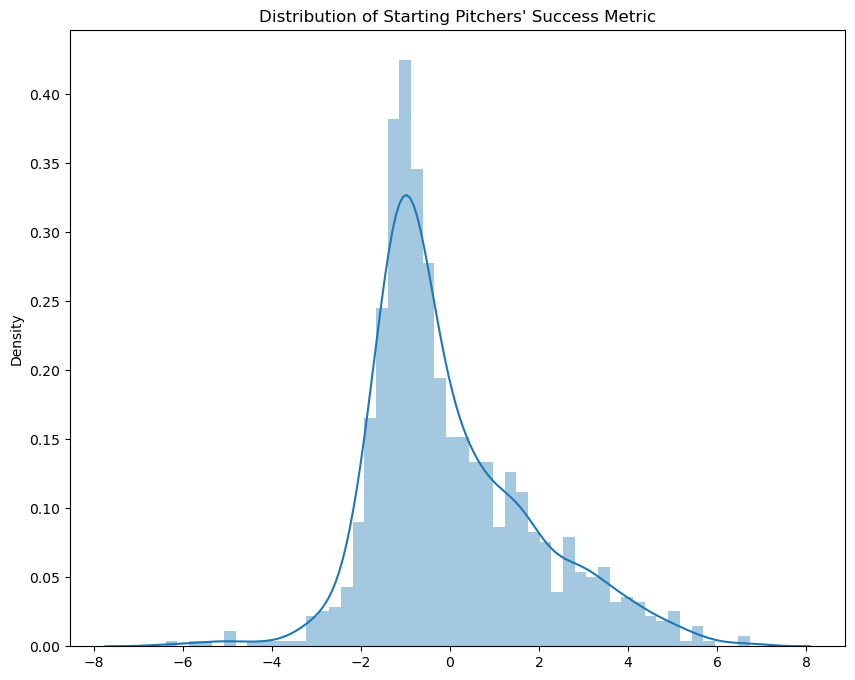

In [10]:
# Creating the starting pitchers metric of succeess: booths_sp_success
pilars = np.array(mergedfgmets[mergedfgmets['Role'] == 'SP'][['WHIP', 'IP', 'WAR']])

# Scaling the pilars
scaler = StandardScaler()
scaled_pilars = scaler.fit_transform(pilars)

'''
For our weighting scheem we want to emphasize that these weights follow
our personal conviction behind the percieved value of these statistics
towards success
'''

# Weighting
weights = np.array([-1.25,1, 1.5])
pca_sp = PCA(n_components=1)

booths_sp_success = pca_sp.fit_transform(scaled_pilars * weights)


# cheching out the final distribution
plt.figure(figsize= (10,8))
sns.distplot(booths_sp_success, bins=50)
plt.title("Distribution of Starting Pitchers' Success Metric")
plt.show()

### Finding the varibales that contribute most to success in this given role- starting pitcher

In [11]:
vars_to_regress = [ "release_speed_1", "release_speed_2", "release_pos_x_1",
                   "release_pos_x_2", "release_pos_z_1", "release_pos_z_2", 
                   "pfx_x_1", "pfx_x_2", "pfx_z_1", "pfx_z_2", "plate_x_1", 
                   "plate_x_2", "plate_z_1", "plate_z_2", "vx0_1", "vx0_2", 
                   "vy0_1", "vy0_2", "vz0_1", "vz0_2", "ax_1", "ax_2", "ay_1", 
                   "ay_2", "az_1", "az_2", "effective_speed_1", "effective_speed_2", 
                   "release_spin_rate_1", "release_spin_rate_2", "release_extension_1", 
                   "release_extension_2", "release_pos_y_1", "release_pos_y_2", 
                   "spin_axis_1", "spin_axis_2",  "G", "GS", "TBF", "W", "L", 
                   "CG", "ShO", "SV", "BS", "HLD", "SD", "MD", "Pulls", "ERA", 
                   "R", "ER", "H", "HR", "SO", "BB", "IBB", "HBP", "WP", "BK",
                    "GB", "LD", "FB", "IFFB", "BU", "IFH", "BUH", "Balls", "Strikes", 
                    "Pitches", "RS", "RS_per_9", "K_pct", "BB_pct", "K_minus_BB_pct", 
                    "K_per_9", "BB_per_9", "K_to_BB", "H_per_9", "HR_per_9", "AVG",  
                    "BABIP", "LOB_pct", "GB_pct", "LD_pct", "FB_pct", "IFFB_pct", 
                    "GB_to_FB", "HR_to_FB", "IFH_pct", "BUH_pct", "FIP", "xFIP", "SIERA", 
                    "tERA", "kwERA", "E_minus_F", "RAR",  "OSwing_pct", "ZSwing_pct", 
                    "Swing_pct", "OContact_pct", "ZContact_pct", "Contact_pct", "Zone_pct", 
                    "FStrike_pct", "SwStr_pct", "CStr_pct", "CSW_pct", "Soft_pct", "Med_pct", 
                    "Hard_pct", "TTO_pct", "EV", "LA", "Barrels", "Barrel_pct", "HardHit", 
                    "HardHit_pct", "botERA", "botOvr", "botStf", "botCmd", "botxRV100", 
                    "Stuff_plus", "Location_plus", "Pitching_plus", "Throws_L"]

Xsp = mergedfgmets[mergedfgmets['Role'] == 'SP'][vars_to_regress].infer_objects() # makes sure of floats
Xsp['Throws_L'] = Xsp['Throws_L'].astype('float')
# y is booths_sp_success

import pandas as pd
import numpy as np

# Construct funtion to determine pval of single variable regression with success
def regress_and_extract_pvalue(column, y):
    X = sm.add_constant(Xsp[column])
    # Regression of y on x
    model = sm.OLS(y, np.array(X))
    results = model.fit()
    p_value = results.pvalues[1]  # pval of slope
    
    return (column, p_value)

# Iterate over each column and construct df output
p_values = [regress_and_extract_pvalue(column, booths_sp_success) for column in Xsp.columns]
p_values_df = pd.DataFrame(p_values, columns=['column', 'p_value'])
p_values_df_sorted = p_values_df.sort_values('p_value').reset_index(drop=True)
print(p_values_df_sorted)

                  column        p_value
0                     SO   0.000000e+00
1                    RAR   0.000000e+00
2                      W   0.000000e+00
3                Strikes  4.328403e-314
4                Pitches  2.464378e-297
5                    TBF  8.958670e-294
6                     RS  9.070155e-280
7                     GS  2.522540e-276
8                      G  2.522540e-276
9                  Pulls  1.655592e-269
10                 Balls  7.508399e-262
11                    GB  1.092000e-250
12                    LD  2.107311e-232
13                     H  3.976255e-217
14               HardHit  4.430449e-215
15                    FB  6.711445e-211
16                   IFH  9.921111e-174
17                  IFFB  3.278926e-159
18                    BB  1.114167e-151
19               Barrels  3.891152e-143
20                     R  2.647397e-141
21                    ER  2.524823e-137
22                    HR  3.098333e-108
23                   HBP   2.731539e-99


### After parsing through the list for signifigant drivers that dont comprise the success metric

In [12]:
# Deemed to be interesting with signifigant pval and independance from the success metric
Xsp_10 = Xsp[['Pitching_plus', 'HR_per_9', 'botxRV100', 'Location_plus', 'CSW_pct', 'Stuff_plus', 'HR_per_9', 'Swing_pct', 'K_pct']]


import pandas as pd

# Similar function as above to determin the r^2 with multiple independant vars
def compute_r_squared(variables):
    X = sm.add_constant(Xsp_10[list(variables)]) # combination of 3 
    y = booths_sp_success
    model = sm.OLS(y, X).fit()
    return (variables, model.rsquared)

# Generate all combinations of 3 variables from the 10 columns
variable_combinations = combinations(Xsp_10.columns, 3)

# I parallelized this just in case we added more dimensions
n_jobs = -1  
results = Parallel(n_jobs=n_jobs)(delayed(compute_r_squared)(comb) for comb in variable_combinations)

# Find the combination with the highest R-squared value
best_combination = max(results, key=lambda x: x[1])
print(f"Best combination of variables: {best_combination[0]}")
print(f"Highest R-squared value: {best_combination[1]}")


Best combination of variables: ('HR_per_9', 'Location_plus', 'K_pct')
Highest R-squared value: 0.36872280806451263


### Best Subset regression results:

Upon trimming down signifigant stats in an effort to gain an understanding of signifigant drivers of the success of starting pitchers, we arrived at a set of 9 signifigant drivers that were seemingly independant from the stats in our starting pitchers success metric. In order to further select the most powerful combination of said statistics we drilled further down with a best sebset regression, in which we decided upon selecting 3 of the most signifigant drivers in tadem with one another. The resulting best subset, which explained about 37% of the variance in our success metric, contained an interesting take on what the best blend of attributes should be if you are to make the perfect starting pitcher in a lab!

***Location Plus***- The best subset chose this over stuff plus seemingly emphasising the importance of controll of starting pitchers, which in turn lends itself to going further into games effieciently

***HR_per_9***- No supprise that this stat is a signifigant driver of success, but present along with Location Plus demonstrates the importatnce of hitting spots and forcing the kinds of contact that is desirable (miss hits, GBs, and pop ups)

***K_pct***- If a given pitcher has controll, then the other driver of being a successful pitcher seems to be getting the ball by hitters, mitigating load on the defense and further removing oportunity to score. K_pct truley reflects the overall "nastyness" of a pitcher.

### Finding the varibales that contribute most to success in this given role- relief pitcher

C:\Users\micha\AppData\Local\Temp\ipykernel_18896\2422675364.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(booths_rp_success, bins=50)
c:\Users\micha\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


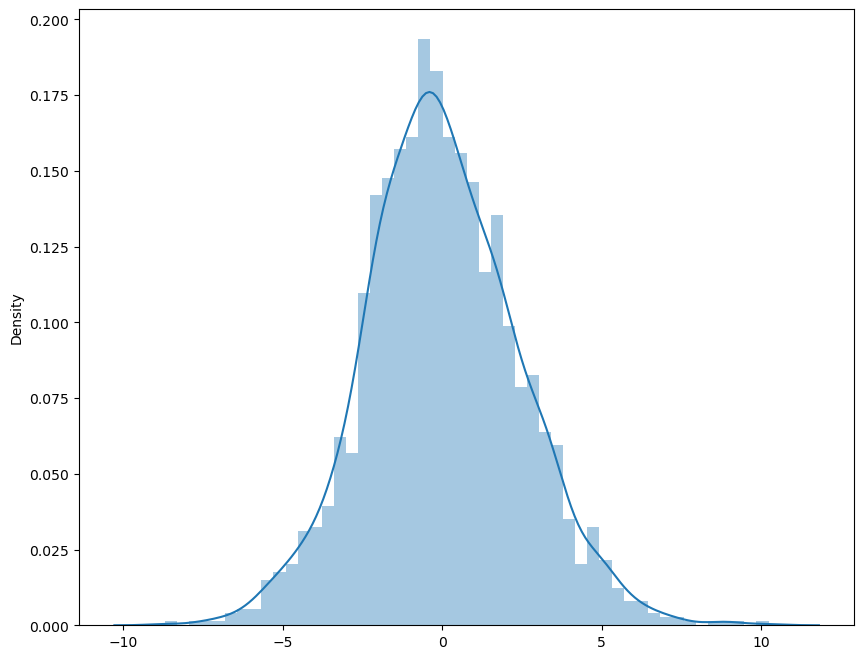

In [13]:
# Creating the starting pitchers metric of succeess: booths_rp_success
pilars = np.array(mergedfgmets[mergedfgmets['Role'] == 'RP'][['WHIP','K_pct', 'IP','G', 'WAR']])

# Scaling the pilars
scaler = StandardScaler()
scaled_pilars = scaler.fit_transform(pilars)

# Weighting
'''
For our weighting scheem we want to emphasize that these weights follow
 our personal conviction behind the percieved value of these statistics
towards success
'''


weights = np.array([-1.25, 2, 1, 1, 1.5])
pca_sp = PCA(n_components=1)

booths_rp_success = pca_sp.fit_transform(scaled_pilars * weights)


# cheching out the final distribution
plt.figure(figsize= (10,8))
sns.distplot(booths_rp_success, bins=50)
plt.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_18896\579632717.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(booths_sp_success, bins=50, ax=axs[0], kde=True, color='DarkGoldenrod')
c:\Users\micha\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\micha\AppData\Local\Temp\ipykernel_18896\579632717.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to us

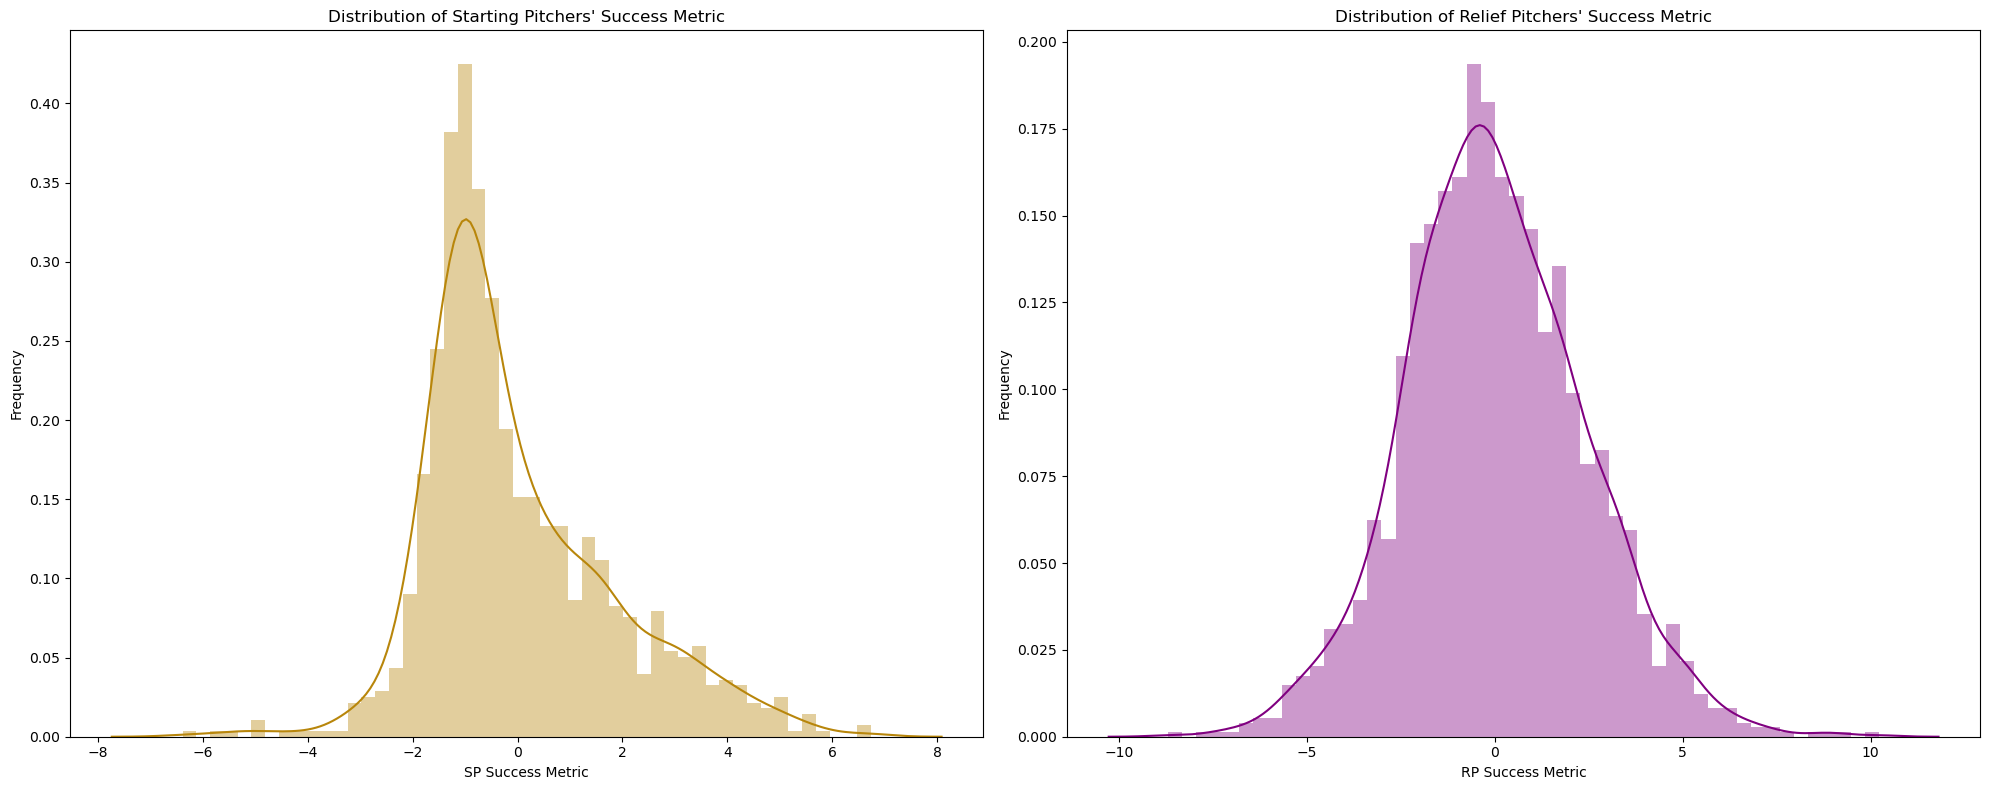

In [14]:
# Create a figure with two subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # figsize adjusted for side-by-side display

# Plot on the first subplot
sns.distplot(booths_sp_success, bins=50, ax=axs[0], kde=True, color='DarkGoldenrod')
axs[0].set_title("Distribution of Starting Pitchers' Success Metric")
axs[0].set_xlabel('SP Success Metric')  # Adjust as necessary
axs[0].set_ylabel('Frequency')  # Adjust as necessary

# Plot on the second subplot (example purposes, replace with your second plot)
sns.distplot(booths_rp_success, bins=50, ax=axs[1], kde=True, color='Purple')
axs[1].set_title("Distribution of Relief Pitchers' Success Metric")
axs[1].set_xlabel('RP Success Metric')  # Adjust as necessary for the second plot
axs[1].set_ylabel('Frequency')  # Adjust as necessary for the second plot

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()

# Display the plots
plt.show()

In [16]:
# Selecting vars to regress
Xrp = mergedfgmets[mergedfgmets['Role'] == 'RP'][vars_to_regress].infer_objects()
Xrp['Throws_L'] = Xrp['Throws_L'].astype('float')
# y is booths_sp_success

# new model incase we decided to hardcode RP metric in the function
def regress_and_extract_pvalueRP(column, y):
    X = sm.add_constant(Xrp[column])
    model = sm.OLS(y, np.array(X))
    results = model.fit()
    p_value = results.pvalues[1]  
    
    return (column, p_value)

# Iterate and put into df for viewing
p_values = [regress_and_extract_pvalueRP(column, booths_rp_success) for column in Xrp.columns]
p_values_df = pd.DataFrame(p_values, columns=['column', 'p_value'])
p_values_df_sorted = p_values_df.sort_values('p_value').reset_index(drop=True)
print(p_values_df_sorted)

                  column        p_value
0         K_minus_BB_pct   0.000000e+00
1                  SIERA   0.000000e+00
2                     SO   0.000000e+00
3                  kwERA   0.000000e+00
4                  K_pct   0.000000e+00
5                K_per_9   0.000000e+00
6                    RAR   0.000000e+00
7                   xFIP  5.677259e-300
8                     SD  1.992484e-280
9                CSW_pct  1.213417e-256
10             SwStr_pct  2.387168e-245
11                     G  3.436738e-245
12               Strikes  4.601439e-240
13               Pitches  7.044050e-230
14           Contact_pct  1.652235e-216
15                   TBF  6.566105e-214
16                 Balls  1.424804e-205
17                   FIP  9.539017e-202
18                  tERA  9.319767e-179
19                 Pulls  2.016053e-171
20                botStf  6.916586e-169
21                     W  6.728001e-166
22                botOvr  2.070033e-158
23                   AVG  1.468271e-157


In [18]:
# Statistically signifigant RP features deemed interesting and independant from the success metric for relievers
Xrp10 = Xrp[['CSW_pct', 'HR_per_9', 'botxRV100', 'Location_plus', 'CSW_pct', 'Stuff_plus', 'HR_per_9', 'effective_speed_1', 'ay_1', 'vy0_1', 'ay_2']]

# Same thing again for the RP
def compute_r_squared_RP(variables):
    X = sm.add_constant(Xrp10[list(variables)])
    y = booths_rp_success
    model = sm.OLS(y, X).fit()
    
    return (variables, model.rsquared)

# Generate all combinations of 3 variables
variable_combinations = combinations(Xrp10.columns, 3)

# Use joblib to parallelize again
n_jobs = -1  
results = Parallel(n_jobs=n_jobs)(delayed(compute_r_squared_RP)(comb) for comb in variable_combinations)
best_combination = max(results, key=lambda x: x[1])
print(f"Best combination of variables: {best_combination[0]}")
print(f"Highest R-squared value: {best_combination[1]}")

Best combination of variables: ('CSW_pct', 'HR_per_9', 'Stuff_plus')
Highest R-squared value: 0.5462557053908084


### Best Subset regression results for RELIEF PITCHERS:

Upon trimming down signifigant stats in an effort to gain an understanding of signifigant drivers of the success of starting pitchers, we arrived at a set of 11 signifigant drivers that were seemingly independant from the stats in our relief pitchers success metric. In order to further select the most powerful combination of said statistics we drilled further down with a best sebset regression, in which we decided upon selecting 3 of the most signifigant drivers in tadem with one another. The resulting best subset, which explained about 55% of the variance in our success metric, contained an interesting take on what the best blend of attributes should be if you are to make the perfect relief pitcher in a lab! The following are some of the most potent drivers to relief pitchers' success:

***CSW_pct***- Called + Swinging Strike Percentage is an extremely importatnt attribute for relievers. Not only to strike batters out, but it also gives the reliever an option to come into a high leverage position where there are runners in scoring position, and ensure strikes are thrown

***HR_per_9***- Again, no supprise that this stat is a signifigant driver of success, but present along with CSW_pct demonstrates the importatnce of inducing swings and forcing the kinds of contact that is desirable (miss hits, GBs, and pop ups)

***Stuff_plus***- This embodies what we think of when we think of "high octane" relievers who have the ability to keep runners off base by way of being difficult to hit! Stuff plus is likley such an important driver due to the high emphasis we think relievers should have on striking hitters out. 

### Now taking a look at the "Offseason Controllables"

Since it appears as if there is a large portion of relief pitching success that is based around a pitcher's "stuff", we further dug into what we deemed to be (somewhat) changable attriburtes during an offseason- specific pitch metrics. The pitch metrics are the average pitch kinematic data that we congieled from the savant data. Any variable ending with a suffix of "_1" is that of the first most common pitch thrown by a given pitcher, and suffix "_2" denotes the second most common pitch. We believe these metrics to be encompassing of a large portion of each pitchers arsenal without the need to drop pitchers who have not yet thrown their third pitch over the last three seasons. 

In [19]:
RPX = mergedfgmets[mergedfgmets['Role'] == 'RP'].loc[:,'release_speed_1':'spin_axis_2']

# Function to compute R-squared for a given combination of variables
def compute_r_squared_RPX(variables):
    X = sm.add_constant(RPX[list(variables)])
    y = booths_rp_success
    model = sm.OLS(y, X.astype('float')).fit()
    return (variables, model.rsquared)

# Generate all combinations of 3 variables from the 10 columns
variable_combinations = combinations(RPX.columns, 3)
n_jobs = -1 
results = Parallel(n_jobs=n_jobs)(delayed(compute_r_squared_RPX)(comb) for comb in variable_combinations) # tried running in parallel due to larger set of combinations

# Find the combination with the highest R-squared value
best_combination = max(results, key=lambda x: x[1])
print(f"Best combination of variables: {best_combination[0]}")
print(f"Highest R-squared value: {best_combination[1]}")

Best combination of variables: ('ay_1', 'ay_2', 'release_pos_y_2')
Highest R-squared value: 0.16322568719624497


Above we run the best subset regression yet again, this time for the physical metrics of ball flight. These metrics we discussed and deem to be somewhat maliable with proper development and training. We see the following 3 ball flight metrics explain the most variance out of any combination for the variance in our relief pitcher's success metric. 

***ay_1***- The average acceleration in the y-direction (up-down) of the most common pitch 

***ay_2***- The average acceleration in the y-direction (up-down) of the second most common pitch 

****+ Corroborating Anecdote****: Acceleration in the y direction makes sense since fastballs that have exceptional carry tunnel extremely well with bowlingball curveballs that drop off a table!

***release_position_y_2***- Release height of the second most common pitch. This variable intruiged us but seems like it could be associated with the balls ability to have vertical break (ay_2)

### Experimental findings EXTRA

Futhermore, we wanted to validate the importance we placed on pitch metrics. In order to do so we used a transformer NN to articulate the abilty to guess ones succeess based soley on average pitch metric. This is seemingly an arbitrary task but we hope to display the ability our model to learn of relief pitchers success soley from ball flight metrics by displaying a decayting loss

In [21]:
# Convert the data to PyTorch tensors
X_tensor = torch.tensor(RPX.infer_objects().values, dtype=torch.float32)
y_tensor = torch.tensor(booths_rp_success, dtype=torch.float32).view(-1, 1)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True) 

# Making the transformer
class TransformerRegressor(nn.Module):

    def __init__(self, input_dim, num_heads, num_layers, forward_expansion, dropout, output_dim=1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, forward_expansion)
        encoder_layer = nn.TransformerEncoderLayer(d_model=forward_expansion, nhead=num_heads, dim_feedforward=forward_expansion, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(forward_expansion, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        embedding = self.dropout(self.embedding(src))
        transformer_out = self.transformer(embedding.unsqueeze(0))  # Add sequence dimension
        out = self.output(transformer_out.squeeze(0))  # Remove the sequence dimension
        return out

# Adjusted hyperparameters... Although we did not specifically hyperparam tune, these params worked very well
input_dim = RPX.shape[1]
num_heads = 4
num_layers = 2
forward_expansion = 32
dropout = 0.5
output_dim = 1

# model
model = TransformerRegressor(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, forward_expansion=forward_expansion, dropout=dropout, output_dim=output_dim)

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function, optimizer, LR Scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9) 

# Losses
lrsT = []

num_epochs = 2000  

# Begin training
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []  
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # GPU
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        predictions = model(data)
        loss = criterion(predictions, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    lrsT.append(epoch_loss)
    scheduler.step()  # Update LR

    # Print Update every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}")

c:\Users\micha\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\micha\anaconda3\envs\py310\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/2000, Average Loss: 5.9432
Epoch 11/2000, Average Loss: 5.7119
Epoch 21/2000, Average Loss: 5.7583
Epoch 31/2000, Average Loss: 5.5861
Epoch 41/2000, Average Loss: 5.5716
Epoch 51/2000, Average Loss: 5.5047
Epoch 61/2000, Average Loss: 5.5027
Epoch 71/2000, Average Loss: 5.4076
Epoch 81/2000, Average Loss: 5.4047
Epoch 91/2000, Average Loss: 5.3549
Epoch 101/2000, Average Loss: 5.2368
Epoch 111/2000, Average Loss: 5.2552
Epoch 121/2000, Average Loss: 5.3238
Epoch 131/2000, Average Loss: 5.2176
Epoch 141/2000, Average Loss: 5.1892
Epoch 151/2000, Average Loss: 5.2875
Epoch 161/2000, Average Loss: 5.2561
Epoch 171/2000, Average Loss: 5.1823
Epoch 181/2000, Average Loss: 5.1742
Epoch 191/2000, Average Loss: 5.2380
Epoch 201/2000, Average Loss: 5.1500
Epoch 211/2000, Average Loss: 5.1681
Epoch 221/2000, Average Loss: 5.1228
Epoch 231/2000, Average Loss: 5.1144
Epoch 241/2000, Average Loss: 5.0736
Epoch 251/2000, Average Loss: 5.1327
Epoch 261/2000, Average Loss: 5.0211
Epoch 271/20

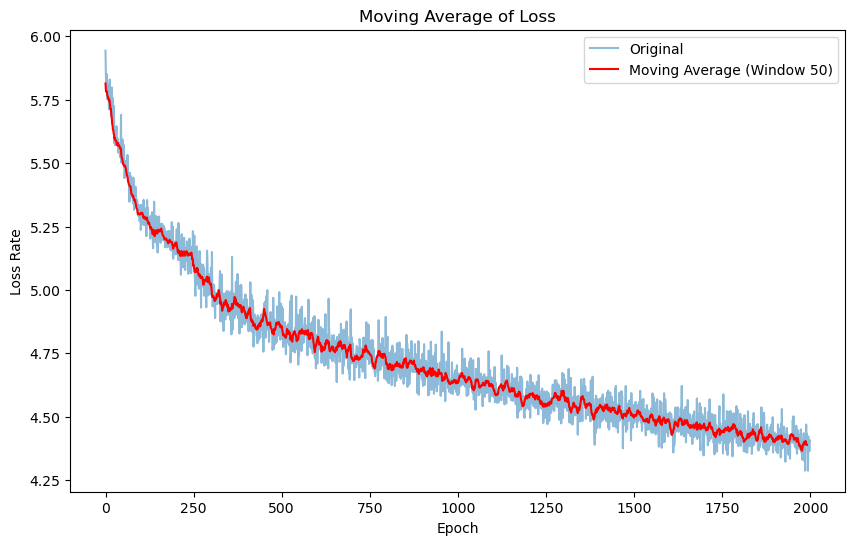

In [22]:
# Compute the moving average with a window length of 50
window_length = 10
window = np.ones(window_length) / window_length
lrs_moving_avg = np.convolve(lrsT, window, 'valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lrsT, label='Original', alpha=0.5)  # Original data, making it semi-transparent
plt.plot(lrs_moving_avg, label='Moving Average (Window 50)', color='red')  # Moving average
plt.title('Moving Average of Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate')
plt.legend()
plt.show()

Based on this naive model we can start to conclude that just average ball flight metrics can be a predictor of reliefe pitchers success. In this case we can also conclude that Driveline and Tread will stay in business!